# Hello, World!

This notebook is about your first steps with knowledge graph embedding models in PyKEEN.

You'll get to do the following:

1. train a model
2. evaluate how good it learned
3. turn it around and start making predictions.

In [1]:
import getpass
import os
import sys
import time

import matplotlib.pyplot as plt
import pandas as pd
import pykeen
import torch
from pykeen.pipeline import pipeline

%matplotlib inline

In [2]:
print(sys.version)

3.8.3 (default, Jul  7 2020, 13:04:12) 
[Clang 11.0.3 (clang-1103.0.32.62)]


In [3]:
print(time.asctime())

Wed Aug 12 19:44:11 2020


In [4]:
print(getpass.getuser())

cthoyt


In [5]:
print(pykeen.get_version(with_git_hash=True))

1.0.3-dev-da26ae4b


## Train a Model

More tutorials on training your first model can be found [here](https://pykeen.readthedocs.io/en/latest/first_steps.html).

You can try switching out the model, add a `loss`, a `regularizer`, or switch the training assumption from `sLCWA` to `LCWA`. Each also has their own hyper-parameters, though PyKEEN tries to have reasonable defaults for you. The most useful one to change is the `num_epochs` in the `training_kwargs`, which is already below.

In [6]:
result = pipeline(
    dataset='Nations',
    model='RotatE',
    random_seed=1235,
    device='cpu',
    training_kwargs=dict(num_epochs=100),  # Shouldn't take more than a minute or two on a nice computer
)

INFO:pykeen.training.training_loop:using stopper: <pykeen.stoppers.stopper.NopStopper object at 0x14e803eb0>


INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...


INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=201.


INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds


Save the trained model (which contains the triples and all of the learned parameters), the results from training, and all of the experimental metadata.

In [7]:
save_location = 'nations_transe'  # relative to here
result.save_to_directory(save_location)
os.listdir(save_location)

['results.json', 'metadata.json', 'trained_model.pkl']

In [8]:
# How to look at the model
model = result.model
model

RotatE(
  (loss): MarginRankingLoss()
  (regularizer): NoRegularizer()
  (entity_embeddings): Embedding(14, 400)
  (relation_embeddings): Embedding(55, 400)
)

In [9]:
# How to look at the triples
tf = model.triples_factory
tf

TriplesFactory(path="/Users/cthoyt/dev/pykeen/src/pykeen/datasets/nations/train.txt")

In [10]:
tf.num_entities, tf.num_relations, tf.num_triples

(14, 55, 1592)

## Evaluating the Results

Check that the loss is going down (and not oscillating) by plotting in the notebook.

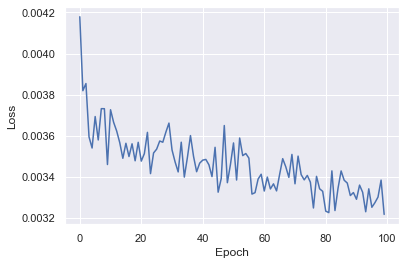

In [11]:
result.plot_losses()
plt.show()

Look at the result. These are pretty tricky to interpret, so remember:

- adjusted mean rank is between [0, 1]. Closer to 1 is better!
- mean rank is a positive integer, with a bound based on the number of entities. Closer to 0 is better!
- hits@k is reported between [0, 1] and interpreted as a percentage. Closer to 1 is better!

In [12]:
result.metric_results.to_df()

,Side,Type,Metric,Value
0,head,avg,adjusted_mean_rank,0.974841
1,both,avg,adjusted_mean_rank,0.853866
2,tail,avg,adjusted_mean_rank,0.732890
3,head,avg,mean_rank,4.492537
4,head,avg,mean_reciprocal_rank,0.391053
5,head,avg,hits_at_1,0.184080
6,head,avg,hits_at_3,0.487562
7,head,avg,hits_at_5,0.691542
8,head,avg,hits_at_10,0.950249
9,head,best,mean_rank,4.492537


## Turn it around: make predictions

It's very difficult to interpret KGEMs statistically, so it's best to sort order the predictions by their scores. All interaction functions in PyKEEN have been implemented such that the higher the score (or less negative the score), the more likely a triple is to be true.

Before making any predictions, we're goign to show some word clouds of the entities and relations in the Nations dataset, with size corresponding to frequency of appearance in triples.

In [13]:
tf.entity_word_cloud()

In [14]:
tf.relation_word_cloud()

In [15]:
from pykeen.datasets import Nations
testing_mapped_triples = Nations().testing.mapped_triples.to(model.device)

In [16]:
# Who do we predict brazil participates in inter-governmental organizations with?
model.predict_tails('brazil', 'intergovorgs', testing=testing_mapped_triples)

,tail_id,tail_label,score,in_training,in_testing
12,12,usa,-4.551726,True,False
11,11,uk,-4.810855,True,False
9,9,netherlands,-5.114554,True,False
4,4,egypt,-5.418498,True,False
5,5,india,-5.427598,True,False
13,13,ussr,-5.452207,False,False
0,0,brazil,-5.577188,False,False
7,7,israel,-5.636818,True,False
2,2,china,-5.637028,False,False
10,10,poland,-5.768697,False,True


In [17]:
# Automatically filter out non-novel predictions (e.g. in training or in testing is True)
model.predict_tails('brazil', 'intergovorgs', testing=testing_mapped_triples, remove_known=True)

,tail_id,tail_label,score
13,13,ussr,-5.452207
0,0,brazil,-5.577188
2,2,china,-5.637028
8,8,jordan,-6.388568
1,1,burma,-6.435104


In [18]:
# Who do we predict to have a conference with brazil?
model.predict_heads('conferences', 'brazil', testing=testing_mapped_triples)

,head_id,head_label,score,in_training,in_testing
12,12,usa,-4.729367,True,False
11,11,uk,-4.894013,False,False
5,5,india,-4.895095,True,False
13,13,ussr,-5.108867,True,False
10,10,poland,-5.168697,True,False
9,9,netherlands,-5.345132,False,False
3,3,cuba,-5.654552,True,False
4,4,egypt,-5.740056,False,False
2,2,china,-5.780384,False,False
6,6,indonesia,-5.885899,False,False


In [20]:
# Score all triples
model.score_all_triples(testing=testing_mapped_triples)

,head_id,head_label,relation_id,relation_label,tail_id,tail_label,score,in_training,in_testing
0,12,usa,40,relstudents,12,usa,-3.477952,True,True
1,12,usa,37,relexports,12,usa,-3.632498,True,True
2,11,uk,27,ngo,12,usa,-3.633697,False,True
3,12,usa,53,warning,12,usa,-3.652733,True,True
4,11,uk,15,emigrants3,12,usa,-3.658464,False,True
...,...,...,...,...,...,...,...,...,...
10775,1,burma,3,blockpositionindex,1,burma,-7.388385,True,True
10776,1,burma,39,relngo,1,burma,-7.410907,True,True
10777,8,jordan,10,dependent,1,burma,-7.420520,True,True
10778,1,burma,14,embassy,1,burma,-7.455530,True,True
